# main notebook data-set creation

### Install

In [11]:
!pip install rasterio

     |████████████████████████████████| 19.1MB 1.2MB/s 


In [ ]:
!nvidia smi

/bin/bash: nvidia: command not found


## Imports

In [12]:
import rasterio as rio
import numpy as np
import pandas as pd
import cv2
import os
import math
from google.colab.patches import cv2_imshow

In [13]:
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/WildTech_01/data_creation_data'
os.chdir(project_path)

print(f"Now working in {project_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Now working in /content/drive/MyDrive/kuzikus/WildTech_01/data_creation_data


## Help Functions

In [14]:
def check_output(project_path, output_folder):
    os.chdir(project_path)
    directory = os.path.join(project_path, output_folder)
    if not os.path.exists(directory):
        print("Directory does not exist. Creating now...")
        os.makedirs(directory)
        print(str(directory) + " created.")
    #else:
        #print(str(directory) + " exists.")
    return directory

## Morphological Transformation

### functions morph

In [46]:
#get position in ortho from image name
def get_xy_mask(name):
    s = []
    s = name.split(sep='_')
    x = int(s[-2])
    y = int(s[-1])
    return x,y

#get name from path
def get_name(path):
    s = []
    s = path.split(sep='/')
    name = s[-1][:-4]
    return name

#convert to black and white - runtime is still way to long, but only needed for
#converts every pixel value other than black into white 
def get_bin_mask(mask):
    width = mask.shape[0] 
    height = mask.shape[1] 
    for i in range(0,width):# process all pixels
        for j in range(0,height):
            data = mask[i,j]
            if (data[0]!=0 or data[1]!=0 or data[2]!=0):
                mask[i,j] = [255,255,255]
    #print('color conversion done.')
    mask_gray = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
    ret,mask_bin = cv2.threshold(mask_gray,127,255,cv2.THRESH_BINARY)
    return mask_bin, mask
   
#morphological transformation
#uses dilation and erosion based on the input chosen, i.e., input other than 0 enables that particular kernel
def morph (img,kernel_er1,kernel_di1,kernel_er2,kernel_di2):  
    if str(kernel_er1) != '0':
        img = cv2.erode(img,kernel_er1,iterations = 1)
    if str(kernel_di1) != '0':
        img = cv2.dilate(img,kernel_di1,iterations = 1)
    if str(kernel_er2) != '0':
        img = cv2.erode(img,kernel_er2,iterations = 1)
    if str(kernel_di2) != '0':
        img = cv2.dilate(img,kernel_di2,iterations = 1)
    #print('morph done.')
    return img
# This function is used to calculate the centroid of the contours
def center (contour):
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return (cx, cy)
# An explanation of the working of this function would be helpful. 
def fit_line(crop_bin_imgs):
    line_xy = []
    line_lengths = []
    for crop_bin_img in crop_bin_imgs:   
        #find contour 
        contours,hierarchy = cv2.findContours(crop_bin_img, 1, 2)
        cnt = contours[0]
        #fit line and get coordinates - NOT STABLE
        rows,cols = crop_bin_img.shape[:2]
        [vx,vy,x,y] = cv2.fitLine(cnt, cv2.DIST_L2,0,0.01,0.01)
        lefty = int((-x*vy/vx) + y)
        righty = int(((cols-x)*vy/vx)+y)
        if vx > 0:
            #create black image with white line
            image_line = np.zeros((crop_bin_img.shape))
            img_line = cv2.line(image_line,(cols-1,righty),(0,lefty),(170,255,0),2)
            #overlay of line and contour
            img_sum = img_line+crop_bin_img
            img_sum[img_sum<256] = 0 #turn all pixel not 425 (line+white contour)
            #find pixels in line
            line_x, line_y = np.where(img_sum > 256)
            line_xy.append([line_x, line_y])
            #find line length
            length = math.sqrt((line_x[-1]-line_x[0])**2+(line_y[-1]-line_y[0])**2)
            line_lengths.append(length)
        else:
            print('No line found.')
            line_xy.append([[], []])
            line_lengths.append(0)
    return line_xy, line_lengths

def draw_contours(img_name, mask, mask_rgb, show_cnt, gps_trans, min_area, max_area):
    contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #take img_rgb to show in color again
    if show_cnt == 1:
        img_cnt = cv2.drawContours(mask_rgb, contours, -1, (0,255,0), 3)
        cv2_imshow(img_cnt)
    #create df    
    features = {"name":[],"gps":[],"x_ortho":[],"y_ortho":[],"x_mask":[],"y_mask":[],"w_bb":[],"h_bb":[],"perimeter":[],"area":[],"centroid":[]}
    i=0
    f_contours = []
    for c in contours:
        features["name"].append(img_name+"_cnt_"+str(i))
        x,y,w,h = cv2.boundingRect(c)
        x_mask, y_mask = get_xy_mask(img_name) 
        x_cnt = x+x_mask
        y_cnt = y+y_mask
        if gps_trans != 0:
            features["gps"].append(gps_trans*(x_cnt,y_cnt))
        else: 
            features["gps"].append(0)
        features["x_ortho"].append(x_cnt)
        features["y_ortho"].append(y_cnt)
        features["x_mask"].append(x)
        features["y_mask"].append(y)
        features["w_bb"].append(w)
        features["h_bb"].append(h)
        features["perimeter"].append(cv2.arcLength(c,True)) # true is used when a closed contour is used as an input
        features["area"].append(cv2.contourArea(c))
        features["centroid"].append(center(c))
        i+=1
        if cv2.contourArea(c) > min_area and cv2.contourArea(c) < max_area:
            f_contours.append(c)
    
    img_cnt_f = cv2.drawContours(np.zeros(mask.shape), f_contours, -1, (1), thickness=cv2.FILLED)
    df_feat = pd.DataFrame(features)
    #filter out small contours
    df_feat = df_feat[df_feat["area"]>min_area]
    df_feat = df_feat[df_feat["area"]<max_area]
    
    return df_feat, img_cnt_f
    
#what are the input parameters x_add and y_add ?
def crop_shadows(df, bin_img, rgb_img, x_add, y_add):
    bin_imgs=[]
    rgb_imgs=[]
    for i in df.index:
        if df['y_mask'][i] > y_add:
            y = df['y_mask'][i] - y_add
        else: 
            y = 0
        if df['x_mask'][i] > x_add:
            x = df['x_mask'][i] - x_add
        else: 
            x = 0 
        bin_imgs.append(bin_img[y:y+df['h_bb'][i]+y_add,x:x+df['w_bb'][i]+x_add])
        rgb_imgs.append(rgb_img[y:y+df['h_bb'][i]+y_add,x:x+df['w_bb'][i]+x_add][:]) 
    return bin_imgs,rgb_imgs

def save_shadows(project_path, df_cnt, imgs, output_folder):
    dir = check_output(project_path, output_folder)
    for j in range(len(imgs)):
        c_name = df_cnt.iloc[j]["name"]
        path = str(dir)+'/'+c_name+'.jpg'
        if not os.path.exists(path):
            cv2.imwrite(path, imgs[j])
        else: 
            print(str(c_name)+' exists already')

### pipeline functions

In [47]:
def create_data(project_path, path_mask, path_rgb, ker_er1, ker_di1, ker_er2, ker_di2, x_add, y_add, gps_trans, min_area, max_area, lines, output, output_folder_mask, output_folder_rgb):
    name = get_name(path_mask)
    if os.path.exists(path_rgb):
        rgb = cv2.imread(path_rgb)
    else:
        print(str(path_rgb) + "does exists. Image can not be processed.")
        return
    mask = cv2.imread(path_mask)
    mask_bin, mask_rgb = get_bin_mask(mask)
    mask_morph = morph(mask_bin,ker_er1,ker_di1,ker_er2,ker_di2)
    #print('mask done.')
    df_cnt, img_cnt_f = draw_contours(name, mask_morph, rgb, 0, gps_trans, min_area, max_area)
    mask_crop,rgb_crop = crop_shadows(df_cnt, mask_morph, rgb, x_add, y_add)
    if lines == 1:
        where_lines, line_lengths = fit_line(mask_crop)
        df_cnt["line"] = where_lines
        df_cnt["l_length"] = line_lengths
    if output == 1:
        save_shadows(project_path, df_cnt, mask_crop, output_folder_mask)
        save_shadows(project_path, df_cnt, rgb_crop, output_folder_rgb)
        #print('saved.')
    return df_cnt, img_cnt_f

def create_data_from_folder(max_num_img, project_path, path_knn_imgs, path_rgb_imgs, ker_er1, ker_di1, ker_er2, ker_di2, x_add, y_add, gps_trans, min_area, max_area, lines, output, output_folder_mask, output_folder_rgb, output_folder_df):
    df_morph = pd.DataFrame()
    i = 0
    for entry in os.scandir(project_path+'/'+path_knn_imgs):
        if entry.path.endswith('.png') and i != max_num_img:
            i+=1
            path_rgb = project_path+'/'+path_rgb_imgs+'/'+entry.name
            df_cnt = create_data(project_path, entry.path, path_rgb, ker_er1, ker_di1, ker_er2, ker_di2, x_add, y_add, gps_trans, min_area, max_area, lines, output, output_folder_mask, output_folder_rgb)
            df_morph = df_morph.append(df_cnt)
            df_morph = df_morph.reset_index(drop=True)
            print(entry.name+' done.')
    df_morph.to_csv(output_folder_df, ';')
    print('finish!!')
    return df_morph

In [48]:
#get transform matrix example
ortho = rio.open(project_path+'/00_input_ortho/ortho.tif')
print(ortho.transform)

| 0.04, 0.00, 236929.26|
| 0.00,-0.04, 7430834.93|
| 0.00, 0.00, 1.00|


### common parameters

In [49]:
#kernels for morph transformation, if == 0 kernel will be ignored
KER_ER1 = np.ones((3,3),np.uint8)     #for humid (3,3); for dry (2,2)
KER_DI1 = np.ones((30,30),np.uint8)   #for humid (30,30); for dry (20,20)
KER_ER2 = np.ones((7,7),np.uint8)
KER_DI2 = 0 #np.ones((1,1),np.uint8)
#add space on left(x) and top(y) of contour bounding box for cut out
X_ADD = 50                        
Y_ADD = 50
#gps_matrix - does not work for full folder, as the matrix changes depending on
#the coordinates of the mask_slice
GPS_TRANS = ortho.transform #if == 0, df_cnt['gps'] = 0
#min/max area for contours to be relevant
MIN_AREA = 4600     #smaller is often grass
MAX_AREA = 250000   #larger is often black area outside picture
LINES = 1 #1 if you want to get line approximation in df
#saving pngs
OUTPUT = 1 #1 if you want save contours and RGB as png
OUT_FOLD_MASK = '03_contours_mask/humid'
OUT_FOLD_RGB = '04_contours_rgb/humid'

### single mask

In [50]:
path_mask = project_path+'/02_knn/humid_knn/rgb_transparent_mosaic_group1-001_49152_6144.png'
path_rgb = project_path+'/02_knn/humid_imgs_sliced/rgb_transparent_mosaic_group1-001_49152_6144.png'

df, mask_morph = create_data(project_path, path_mask, path_rgb, KER_ER1, KER_DI1, KER_ER2, KER_DI2, X_ADD, Y_ADD, GPS_TRANS, MIN_AREA, MAX_AREA, LINES, OUTPUT, OUT_FOLD_MASK, OUT_FOLD_RGB)
df

No line found.
No line found.
No line found.
rgb_transparent_mosaic_group1-001_49152_6144_cnt_31 exists already
rgb_transparent_mosaic_group1-001_49152_6144_cnt_47 exists already
rgb_transparent_mosaic_group1-001_49152_6144_cnt_77 exists already
rgb_transparent_mosaic_group1-001_49152_6144_cnt_121 exists already
rgb_transparent_mosaic_group1-001_49152_6144_cnt_127 exists already
rgb_transparent_mosaic_group1-001_49152_6144_cnt_148 exists already
rgb_transparent_mosaic_group1-001_49152_6144_cnt_160 exists already
rgb_transparent_mosaic_group1-001_49152_6144_cnt_164 exists already
rgb_transparent_mosaic_group1-001_49152_6144_cnt_181 exists already
rgb_transparent_mosaic_group1-001_49152_6144_cnt_183 exists already
rgb_transparent_mosaic_group1-001_49152_6144_cnt_194 exists already
rgb_transparent_mosaic_group1-001_49152_6144_cnt_203 exists already
rgb_transparent_mosaic_group1-001_49152_6144_cnt_225 exists already
rgb_transparent_mosaic_group1-001_49152_6144_cnt_234 exists already
rgb_tr

,name,gps,x_ortho,y_ortho,x_mask,y_mask,w_bb,h_bb,perimeter,area,centroid,line,l_length
31,rgb_transparent_mosaic_group1-001_49152_6144_c...,"(238958.26613930383, 7430517.666206767)",49500,7740,348,1596,69,185,630.041630,5400.5,"(385, 1686)","[[180, 180, 181, 181, 181, 181, 181, 182, 182,...",94.936821
47,rgb_transparent_mosaic_group1-001_49152_6144_c...,"(238962.20117976793, 7430521.273326689)",49596,7652,444,1508,181,173,1076.669047,11217.5,"(541, 1593)","[[], []]",0.000000
77,rgb_transparent_mosaic_group1-001_49152_6144_c...,"(238970.07126069613, 7430527.175886564)",49788,7508,636,1364,105,101,433.556349,5637.5,"(684, 1411)","[[147, 147, 147, 147, 147, 147, 147, 147, 147,...",76.026311
121,rgb_transparent_mosaic_group1-001_49152_6144_c...,"(238997.2886239062, 7430537.505366343)",50452,7256,1300,1112,321,289,1290.509666,59590.0,"(1469, 1258)","[[], []]",0.000000
127,rgb_transparent_mosaic_group1-001_49152_6144_c...,"(239019.42322651678, 7430539.308926305)",50992,7212,1840,1068,121,153,784.183766,7822.5,"(1903, 1149)","[[80, 81, 82, 90, 90, 90, 90, 90, 91, 91, 91, ...",204.401566
148,rgb_transparent_mosaic_group1-001_49152_6144_c...,"(239007.12622506646, 7430545.703366169)",50692,7056,1540,912,169,113,630.183766,9813.5,"(1613, 974)","[[72, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, ...",135.650286
160,rgb_transparent_mosaic_group1-001_49152_6144_c...,"(239022.70242690353, 7430548.3267261125)",51072,6992,1920,848,128,137,687.355338,7660.5,"(1997, 910)","[[143, 143, 144, 144, 144, 145, 145, 145, 145,...",68.410526
164,rgb_transparent_mosaic_group1-001_49152_6144_c...,"(238957.7742592458, 7430548.982566099)",49488,6976,336,832,273,257,1072.166521,43689.0,"(466, 964)","[[], []]",0.000000
181,rgb_transparent_mosaic_group1-001_49152_6144_c...,"(239019.9151065748, 7430557.34452592)",51004,6772,1852,628,196,225,1005.012193,14048.5,"(1973, 728)","[[271, 271, 271, 271, 271, 271, 271, 271, 271,...",55.036352
183,rgb_transparent_mosaic_group1-001_49152_6144_c...,"(238944.00161762146, 7430558.328285899)",49152,6748,0,604,109,257,1092.083260,12865.0,"(54, 719)","[[225, 225, 225, 225, 225, 225, 225, 225, 225,...",80.024996


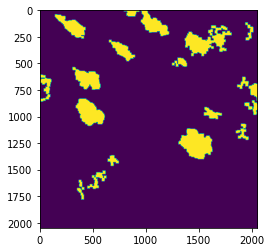

In [55]:
import matplotlib.pyplot as plt

plt.imshow(mask_morph)
cv2.imwrite("test_dummy_bin.png", mask_morph*255)
df.to_csv("dummy.csv")

### mask folder

In [ ]:
out_fold_df = '05_df/humid_df.csv'
path_knn_imgs = '02_knn/humid_knn'
path_rgb_imgs = '02_knn/humid_imgs_sliced'
max_num_img = 2 #maximal number of pics the loop goes through

df_morph = create_data_from_folder(max_num_img, project_path, path_knn_imgs, path_rgb_imgs, KER_ER1, KER_DI1, KER_ER2, KER_DI2, X_ADD, Y_ADD, GPS_TRANS, MIN_AREA, MAX_AREA, LINES, OUTPUT, OUT_FOLD_MASK, OUT_FOLD_RGB, out_fold_df)
df_morph

Directory does not exist. Creating now...
/content/drive/MyDrive/WildTech_01/data_creation_data/03_contours_mask/humid created.
Directory does not exist. Creating now...
/content/drive/MyDrive/WildTech_01/data_creation_data/04_contours_rgb/humid created.
rgb_transparent_mosaic_group1-001_0_18432.png done.
No line found.
No line found.
rgb_transparent_mosaic_group1-001_0_20480.png done.
finish!!


,name,gps,x_ortho,y_ortho,x_mask,y_mask,w_bb,h_bb,perimeter,area,centroid,line,l_length
0,rgb_transparent_mosaic_group1-001_0_20480_cnt_3,"(236956.97014326806, 7429919.868059517)",676,22324,676,1844,45,57,194.142135,1957.0,"(697, 1872)","[[58, 58, 58, 59, 59, 59, 60, 60, 60, 61, 61, ...",45.880279
1,rgb_transparent_mosaic_group1-001_0_20480_cnt_5,"(236953.85490290064, 7429925.114779404)",600,22196,600,1716,41,57,189.071068,1890.5,"(620, 1743)","[[54, 54, 55, 55, 55, 56, 56, 57, 57, 57, 58, ...",47.413078
2,rgb_transparent_mosaic_group1-001_0_20480_cnt_6,"(236970.08694481506, 7429926.098539383)",996,22172,996,1692,101,73,335.798990,2887.0,"(1046, 1728)","[[54, 54, 55, 55, 55, 56, 56, 56, 56, 56, 57, ...",118.190524
3,rgb_transparent_mosaic_group1-001_0_20480_cnt_8,"(236941.885821489, 7429929.213779317)",308,22096,308,1616,237,281,1080.509666,38719.0,"(423, 1763)","[[110, 110, 110, 111, 111, 111, 111, 112, 112,...",306.178053
4,rgb_transparent_mosaic_group1-001_0_20480_cnt_11,"(236970.25090483442, 7429934.6244592015)",1000,21964,1000,1484,377,469,2031.563489,76156.0,"(1226, 1736)","[[262, 262, 263, 263, 263, 263, 264, 264, 264,...",422.422774
5,rgb_transparent_mosaic_group1-001_0_20480_cnt_15,"(237010.09318953348, 7429949.544818884)",1972,21600,1972,1120,76,85,312.142135,4051.0,"(2018, 1162)","[[66, 66, 67, 67, 67, 68, 68, 68, 69, 69, 69, ...",46.529560
6,rgb_transparent_mosaic_group1-001_0_20480_cnt_20,"(236940.5741413343, 7429954.463618779)",276,21480,276,1000,41,73,220.485281,2323.0,"(297, 1038)","[[], []]",0.000000
7,rgb_transparent_mosaic_group1-001_0_20480_cnt_21,"(236993.04134752235, 7429958.234698698)",1556,21388,1556,908,433,381,1818.835567,59320.5,"(1776, 1075)","[[278, 278, 278, 279, 279, 279, 280, 280, 280,...",24.738634
8,rgb_transparent_mosaic_group1-001_0_20480_cnt_23,"(236968.61130464103, 7429959.3824186735)",960,21360,960,880,49,53,197.071068,1938.5,"(981, 905)","[[62, 62, 62, 62, 63, 63, 63, 63, 64, 64, 64, ...",48.795492
9,rgb_transparent_mosaic_group1-001_0_20480_cnt_24,"(236974.0219852792, 7429962.497658608)",1092,21284,1092,804,169,145,631.597979,15310.0,"(1175, 875)","[[86, 86, 87, 87, 87, 87, 87, 87, 88, 88, 88, ...",218.680132


In [ ]:
df_morph

,name,gps,x_ortho,y_ortho,x_mask,y_mask,w_bb,h_bb,perimeter,area,centroid,line,l_length
0,rgb_transparent_mosaic_group1-001_0_20480_cnt_3,0,676,22324,676,1844,45,57,194.142135,1957.0,"(697, 1872)","[[58, 58, 58, 59, 59, 59, 60, 60, 60, 61, 61, ...",45.880279
1,rgb_transparent_mosaic_group1-001_0_20480_cnt_5,0,600,22196,600,1716,41,57,189.071068,1890.5,"(620, 1743)","[[54, 54, 55, 55, 55, 56, 56, 57, 57, 57, 58, ...",47.413078
2,rgb_transparent_mosaic_group1-001_0_20480_cnt_6,0,996,22172,996,1692,101,73,335.798990,2887.0,"(1046, 1728)","[[54, 54, 55, 55, 55, 56, 56, 56, 56, 56, 57, ...",118.190524
3,rgb_transparent_mosaic_group1-001_0_20480_cnt_8,0,308,22096,308,1616,237,281,1080.509666,38719.0,"(423, 1763)","[[110, 110, 110, 111, 111, 111, 111, 112, 112,...",306.178053
4,rgb_transparent_mosaic_group1-001_0_20480_cnt_11,0,1000,21964,1000,1484,377,469,2031.563489,76156.0,"(1226, 1736)","[[262, 262, 263, 263, 263, 263, 264, 264, 264,...",422.422774
5,rgb_transparent_mosaic_group1-001_0_20480_cnt_15,0,1972,21600,1972,1120,76,85,312.142135,4051.0,"(2018, 1162)","[[66, 66, 67, 67, 67, 68, 68, 68, 69, 69, 69, ...",46.529560
6,rgb_transparent_mosaic_group1-001_0_20480_cnt_20,0,276,21480,276,1000,41,73,220.485281,2323.0,"(297, 1038)","[[], []]",0.000000
7,rgb_transparent_mosaic_group1-001_0_20480_cnt_21,0,1556,21388,1556,908,433,381,1818.835567,59320.5,"(1776, 1075)","[[278, 278, 278, 279, 279, 279, 280, 280, 280,...",24.738634
8,rgb_transparent_mosaic_group1-001_0_20480_cnt_23,0,960,21360,960,880,49,53,197.071068,1938.5,"(981, 905)","[[62, 62, 62, 62, 63, 63, 63, 63, 64, 64, 64, ...",48.795492
9,rgb_transparent_mosaic_group1-001_0_20480_cnt_24,0,1092,21284,1092,804,169,145,631.597979,15310.0,"(1175, 875)","[[86, 86, 87, 87, 87, 87, 87, 87, 88, 88, 88, ...",218.680132
